In [1]:
import os
import zstandard as zstd
import json
import matplotlib.pyplot as plt
import databento as dbn  # T'as intérêt à avoir installé les libs dbn et zstandard, sinon ça va pas le faire
import pandas as pd

In [2]:

def decompress_zst(zst_path, extract_path):
    """Décompresse un fichier zst comme un boss."""
    with open(zst_path, 'rb') as zst_file:
        dctx = zstd.ZstdDecompressor()
        with open(extract_path, 'wb') as out_file:
            dctx.copy_stream(zst_file, out_file)
    print(f"Bam ! Fichier décompressé dans : {extract_path}")

def load_metadata(metadata_path):
    """Charge les métadonnées du fichier JSON, fastoche."""
    with open(metadata_path, 'r') as f:
        return json.load(f)

def load_symbology(symbology_path):
    """Charge la symbologie du fichier JSON, rien de ouf."""
    with open(symbology_path, 'r') as f:
        return json.load(f)
    
    
    
def visualize_orderbook(dbn_file, symbol):
    """Visualise le carnet d'ordres pour un symbole donné en utilisant @databento."""
    try:
        # On crée un DBNStore à partir du chemin du fichier
        store = dbn.DBNStore.from_file(dbn_file)
        
        # On récupère les données pour le symbole spécifié
        df = store.to_df( # Assurez-vous que c'est le bon schéma pour vos données
        )
    except FileNotFoundError:
        print(f"Erreur : Le fichier {dbn_file} n'a pas été trouvé.")
        return
    except Exception as e:
        print(f"Une erreur s'est produite lors de la lecture du fichier : {str(e)}")
        return
    
    # On vérifie si des données ont été récupérées
    if df.empty:
        print(f"Aucune donnée n'a été trouvée pour le symbole {symbol}")
        return
    # On filtre les données pour ne garder que celles correspondant au symbole spécifié
    df = df[df['symbol'] == symbol]
    
    # On vérifie à nouveau si des données ont été trouvées après le filtrage
    if df.empty:
        print(f"Aucune donnée n'a été trouvée pour le symbole {symbol}")
        return
    # On extrait les données pertinentes
    
    df['timestamp'] = pd.to_datetime(df['ts_event'], unit='ns')
    bids = df[df['side'] == 'A']
    asks = df[df['side'] == 'B']
    none = df[df['side'] == 'N']
    
    # On balance un graphique de ouf
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.scatter(bids['timestamp'], bids['price'], label='Bid', color='green', alpha=0.5, s=bids['size']/10)
    plt.scatter(asks['timestamp'], asks['price'], label='Ask', color='red', alpha=0.5, s=asks['size']/10)
    plt.scatter(none['timestamp'], none['price'], label='None', color='blue', alpha=0.5, s=none['size']/10)
    plt.title(f"Carnet d'ordres pour {symbol}, avec quantité")
    plt.xlabel("Temps")
    plt.ylabel("Prix")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    
    
def main():
    # Le chemin vers le dossier avec tous les trucs dedans
    folder_path = "data"
    
    # On décompresse le fichier zst s'il y en a un
    zst_files = [f for f in os.listdir(folder_path) if f.endswith('.zst')]
    if zst_files:
        zst_path = os.path.join(folder_path, zst_files[0])
        extract_path = os.path.join(folder_path, zst_files[0][:-4]+".dbn")  # On enlève l'extension .zst
        decompress_zst(zst_path, extract_path)
    
    # On charge les métadonnées et la symbologie
    metadata = load_metadata(os.path.join(folder_path, "metadata.json"))
    symbology = load_symbology(os.path.join(folder_path, "symbology.json"))
    
    # On cherche le fichier DBN, ça devrait pas trop galère
    dbn_files = [f for f in os.listdir(folder_path) if f.endswith('.dbn')]
    if not dbn_files:
        print("Merde, pas de fichier DBN dans le dossier.")
        return
    
    dbn_file = os.path.join(folder_path, dbn_files[0])
    
    # On visualise le carnet d'ordres pour chaque symbole
    for symbol in symbology['symbols']:
        visualize_orderbook(dbn_file, symbol)


In [3]:
store = dbn.DBNStore.from_file("data/test.dbn")
df = store.to_df()
df.head()

,ts_event,rtype,publisher_id,instrument_id,action,side,depth,price,size,flags,ts_in_delta,sequence,bid_px_00,ask_px_00,bid_sz_00,ask_sz_00,bid_ct_00,ask_ct_00,symbol
ts_recv,,,,,,,,,,,,,,,,,,,
2024-06-24 13:02:11.422595958+00:00,2024-06-24 13:02:11.422457070+00:00,1,41,13724,T,N,0,9.18,50,194,62023,124114,NaN,NaN,0,0,0,0,RIOT
2024-06-24 13:02:11.422631893+00:00,2024-06-24 13:02:11.422457070+00:00,1,41,13724,T,N,0,9.18,50,194,55493,124115,NaN,NaN,0,0,0,0,RIOT
2024-06-24 13:02:11.429271955+00:00,2024-06-24 13:02:11.429036717+00:00,1,40,13724,T,N,0,9.18,10,130,208905,15342,NaN,NaN,0,0,0,0,RIOT
2024-06-24 13:21:15.485440454+00:00,2024-06-24 13:21:15.485209696+00:00,1,40,13724,T,N,0,9.15,22,130,212297,15503,NaN,NaN,0,0,0,0,RIOT
2024-06-24 13:28:26.527486749+00:00,2024-06-24 13:28:26.527340444+00:00,1,41,13724,T,N,0,9.22,3,194,56964,197477,NaN,NaN,0,0,0,0,RIOT


# Explication des métadonnées (BBO on trade - TBBO)

Les métadonnées fournissent des informations cruciales sur le jeu de données TBBO (BBO on trade). Voici une explication détaillée des champs principaux basée sur le schéma TBBO de Databento :

## Champs principaux

- **publisher_id** (uint16_t) : L'ID de l'éditeur assigné par Databento, indiquant le dataset et la plateforme.
- **instrument_id** (uint32_t) : L'ID numérique de l'instrument financier.
- **ts_event** (uint64_t) : Le timestamp de réception par le moteur d'appariement, en nanosecondes depuis l'époque UNIX.
- **price** (int64_t) : Le prix de l'ordre, où chaque unité correspond à 1e-9 (0,000000001).
- **size** (uint32_t) : La quantité de l'ordre.
- **action** (char) : L'action de l'événement. Toujours "Trade" dans le schéma TBBO.
- **side** (char) : Le côté initiant l'événement (Ask pour vente, Bid pour achat, None si non spécifié).
- **flags** (uint8_t) : Un champ de bits indiquant la fin de l'événement, les caractéristiques du message et la qualité des données.
- **depth** (uint8_t) : Le niveau du carnet d'ordres où l'événement de mise à jour s'est produit.
- **ts_recv** (uint64_t) : Le timestamp de réception par le serveur de capture, en nanosecondes depuis l'époque UNIX.
- **ts_in_delta** (int32_t) : Le timestamp d'envoi par le moteur d'appariement, exprimé en nanosecondes avant ts_recv.
- **sequence** (uint32_t) : Le numéro de séquence du message assigné par la plateforme.
- **bid_px_00** (int64_t) : Le prix bid au niveau supérieur.
- **ask_px_00** (int64_t) : Le prix ask au niveau supérieur.
- **bid_sz_00** (uint32_t) : La taille bid au niveau supérieur.
- **ask_sz_00** (uint32_t) : La taille ask au niveau supérieur.
- **bid_ct_00** (uint32_t) : Le nombre d'ordres bid au niveau supérieur.
- **ask_ct_00** (uint32_t) : Le nombre d'ordres ask au niveau supérieur.

## Importance des métadonnées TBBO

Ces métadonnées sont essentielles pour :

1. Identifier précisément chaque événement de trade et le BBO associé.
2. Comprendre la chronologie exacte des événements grâce aux timestamps détaillés.
3. Analyser la profondeur du marché au moment de chaque trade.
4. Suivre la séquence des messages pour assurer l'intégrité des données.
5. Étudier le comportement des ordres et des trades sur le marché.

Le schéma TBBO fournit une vue détaillée de chaque trade en relation avec l'état du carnet d'ordres, ce qui est crucial pour l'analyse de la microstructure du marché et l'exécution des ordres.


# Explication des métadonnées

Les métadonnées fournissent des informations essentielles sur le jeu de données. Voici une explication détaillée des champs principaux basée sur le fichier `metadata.json` :

## Champs principaux

- **version**: La version du format des métadonnées (exemple: 1).
- **job_id**: L'identifiant unique du job de requête (exemple: "DBEQ-20240924-4468SLPNAT").
- **query**: Contient les détails de la requête :
  - **dataset**: Le nom du jeu de données (exemple: "DBEQ.BASIC").
  - **schema**: Le schéma des données (exemple: "trades").
  - **symbols**: Liste des symboles inclus dans le jeu de données (exemple: ["AAPL", "GOOGL", "MSFT"]).
  - **stype_in**: Le type de symbole en entrée (exemple: "raw_symbol").
  - **stype_out**: Le type de symbole en sortie (exemple: "instrument_id").
  - **start**: Timestamp de début des données en nanosecondes (exemple: 1632441600000000000).
  - **end**: Timestamp de fin des données en nanosecondes (exemple: 1632528000000000000).
  - **limit**: Limite du nombre d'enregistrements (exemple: null si pas de limite, ou 1000000).
  - **encoding**: Format d'encodage des données (exemple: "dbn").
  - **compression**: Méthode de compression utilisée (exemple: "zstd").
- **customizations**: Paramètres de personnalisation :
  - **pretty_px**: Formatage des prix (exemple: false).
  - **pretty_ts**: Formatage des timestamps (exemple: false).
  - **map_symbols**: Mappage des symboles (exemple: false).
  - **split_symbols**: Séparation des symboles (exemple: false).
  - **split_duration**: Durée de séparation (exemple: "day").
  - **split_size**: Taille de séparation (exemple: null ou 1000000000).
  - **packaging**: Type d'emballage (exemple: null ou "zip").
  - **delivery**: Méthode de livraison (exemple: "download").

## Importance des métadonnées

Ces métadonnées sont cruciales pour :

1. Identifier précisément le jeu de données et sa provenance.
2. Comprendre la période couverte par les données.
3. Connaître les symboles inclus et leur format.
4. Savoir comment les données sont encodées et compressées.
5. Comprendre les personnalisations appliquées aux données.

Ces informations sont essentielles pour traiter et analyser correctement les données du carnet d'ordres.

## Exemple complet de métadonnées

Voici un exemple complet de métadonnées :


Bam ! Fichier décompressé dans : data/test.dbn


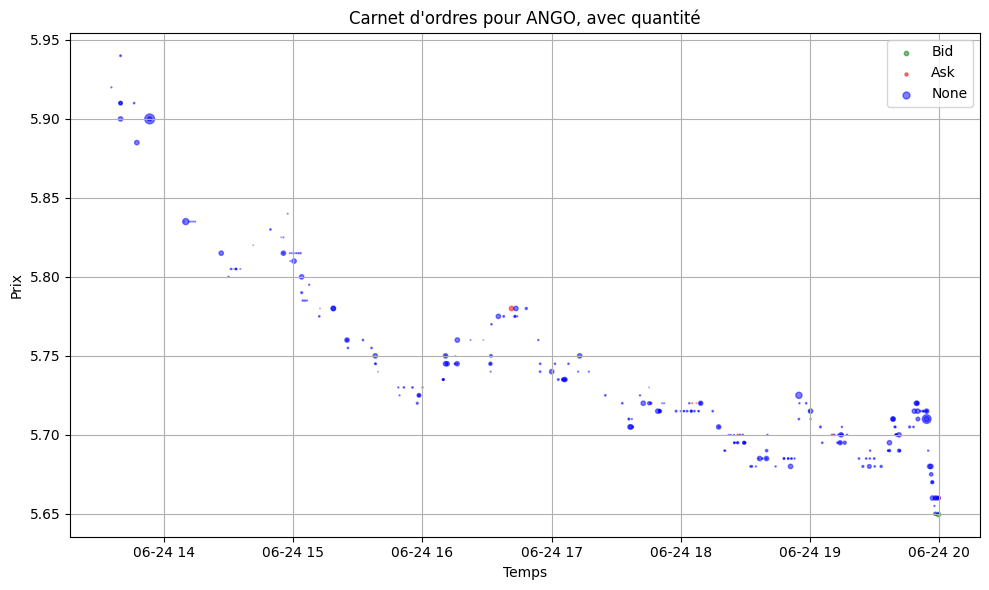

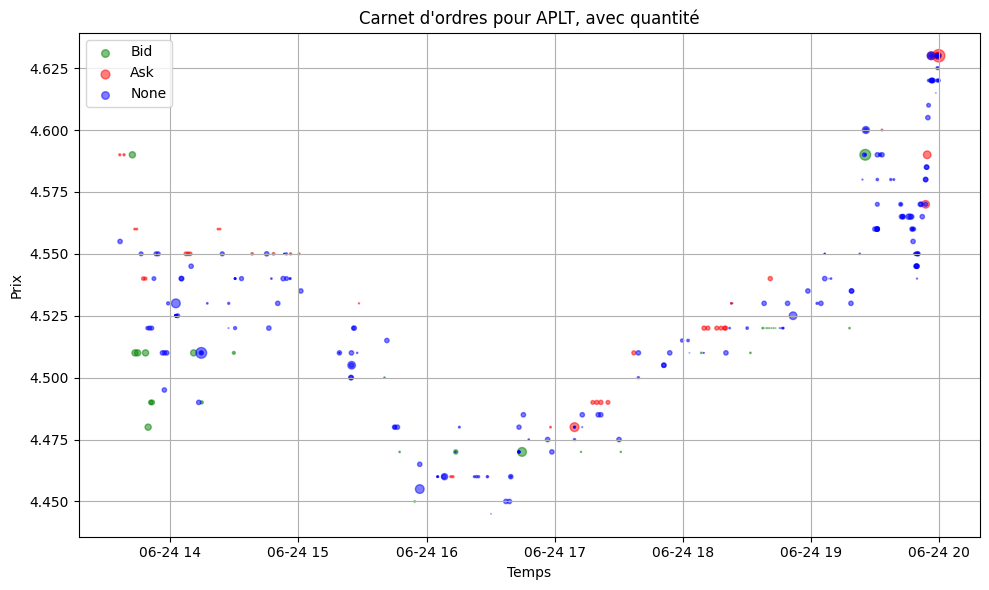

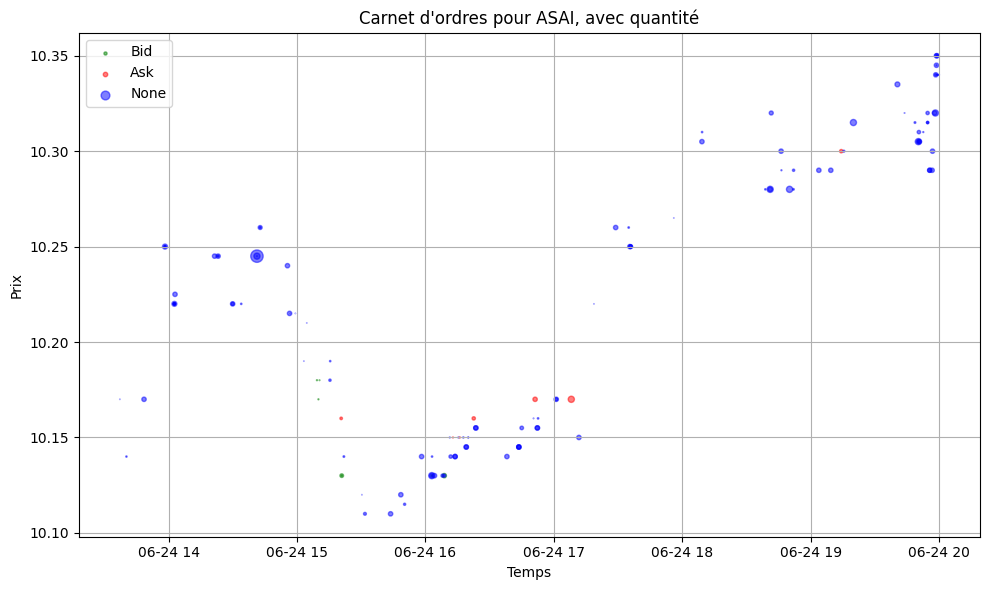

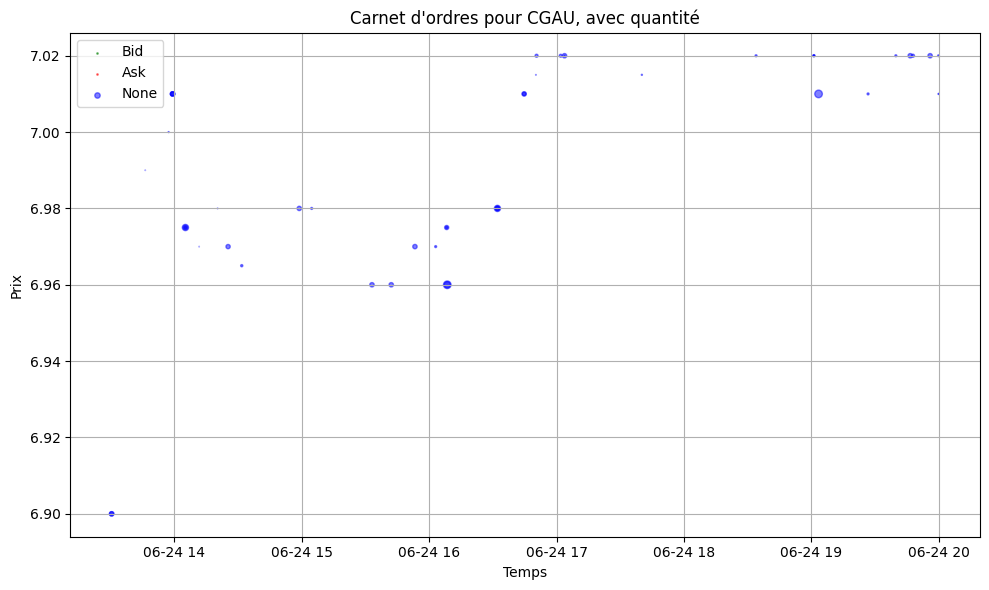

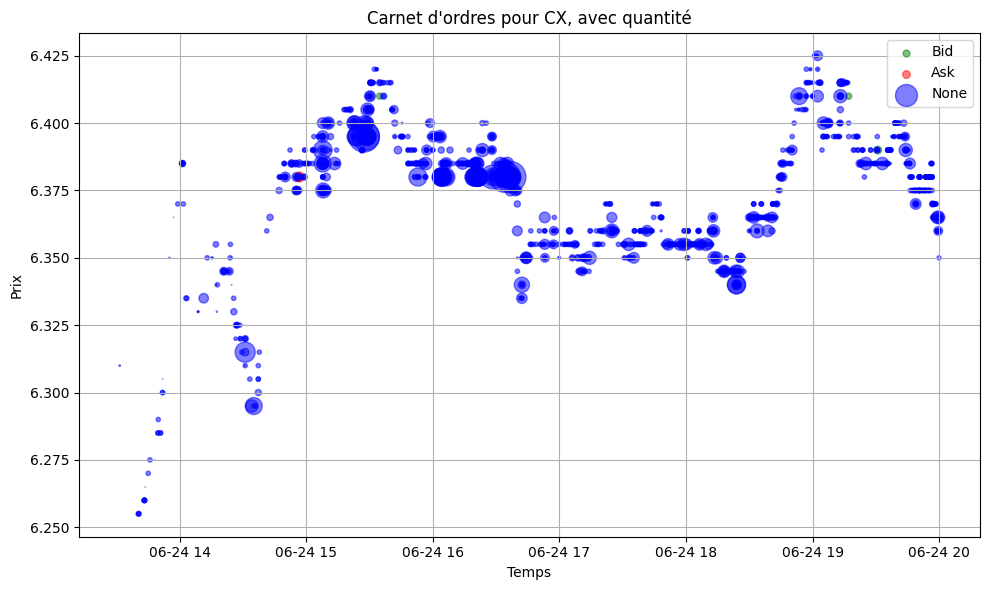

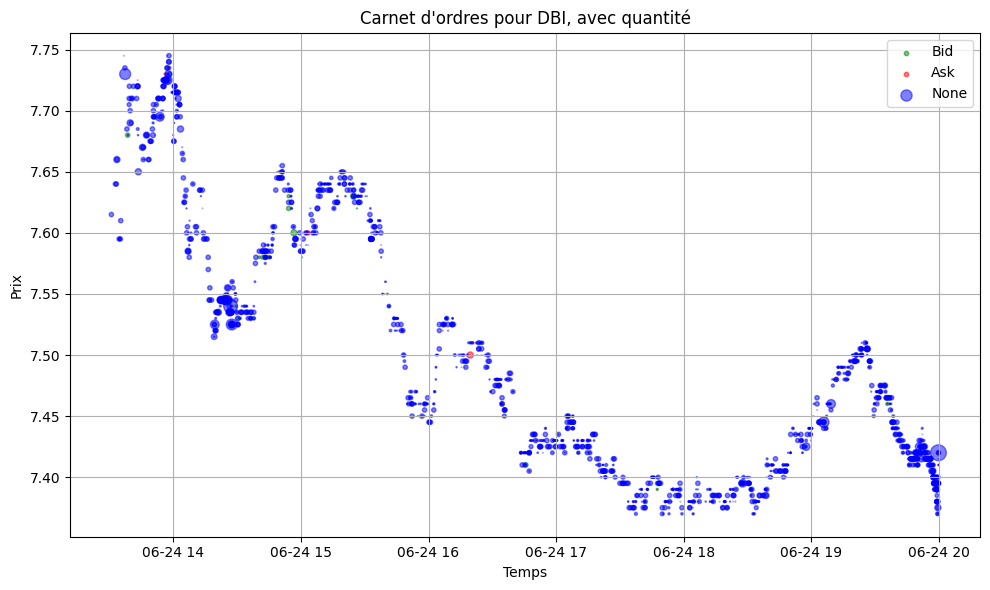

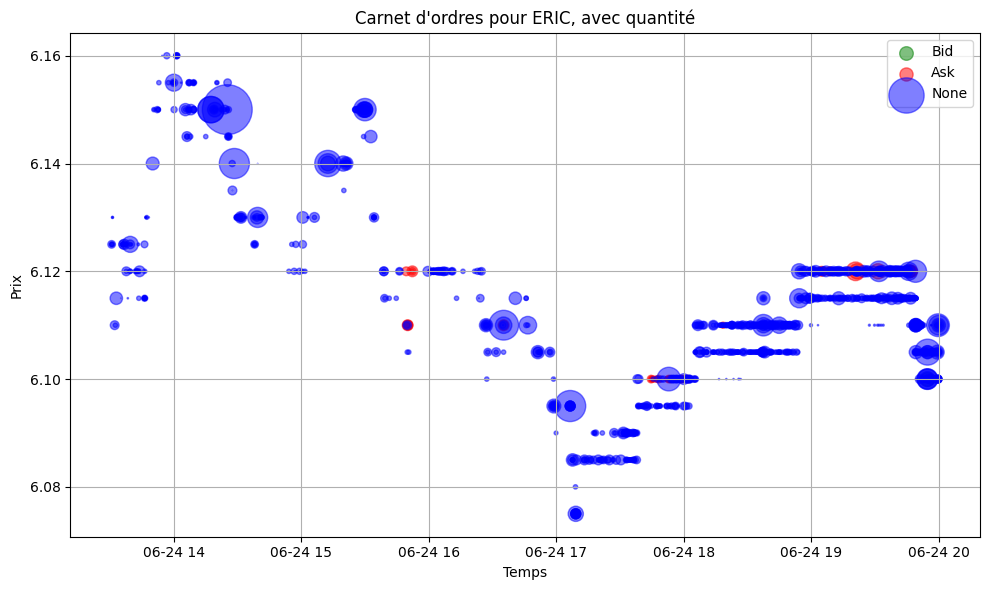

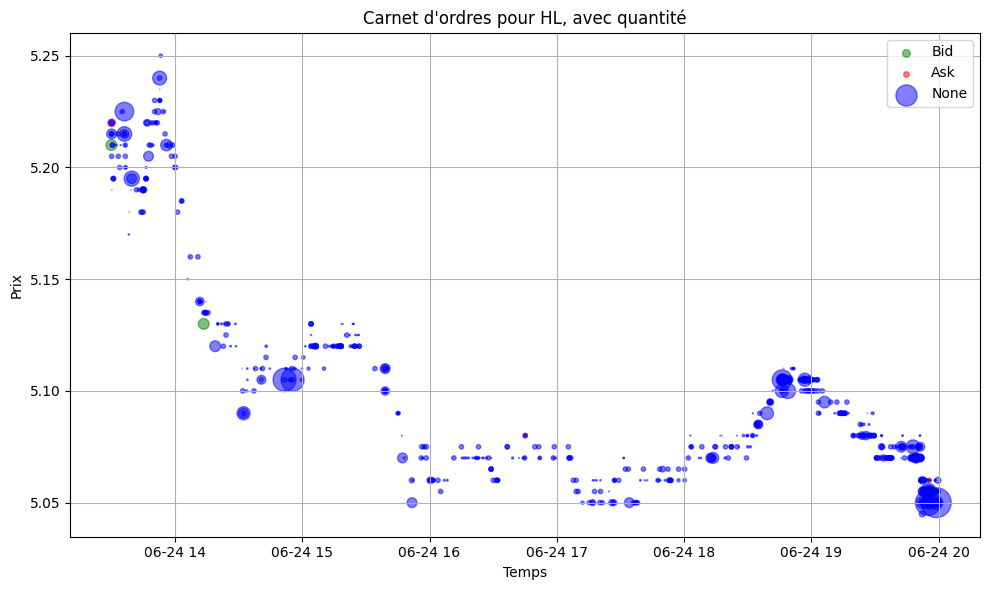

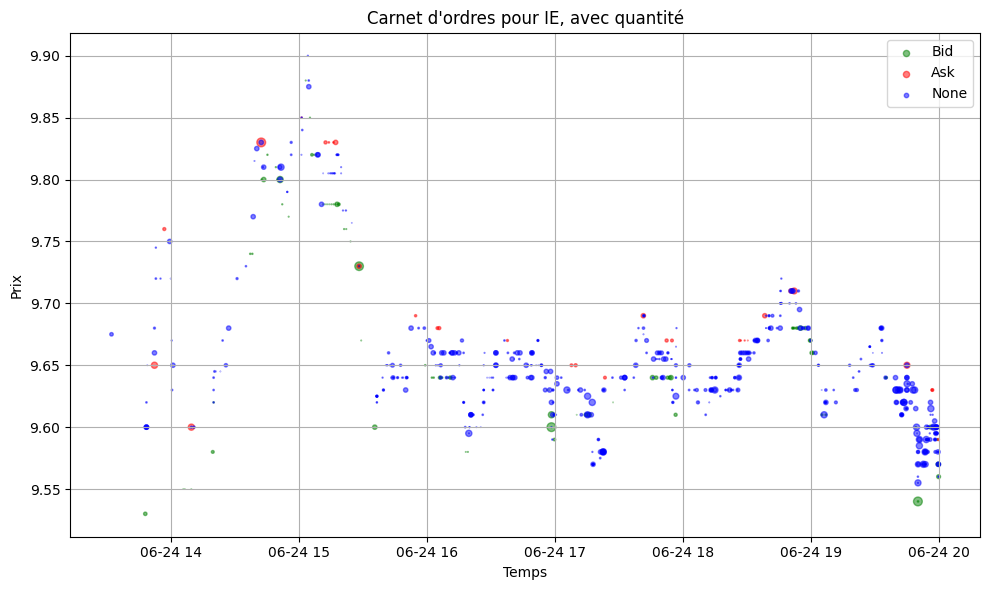

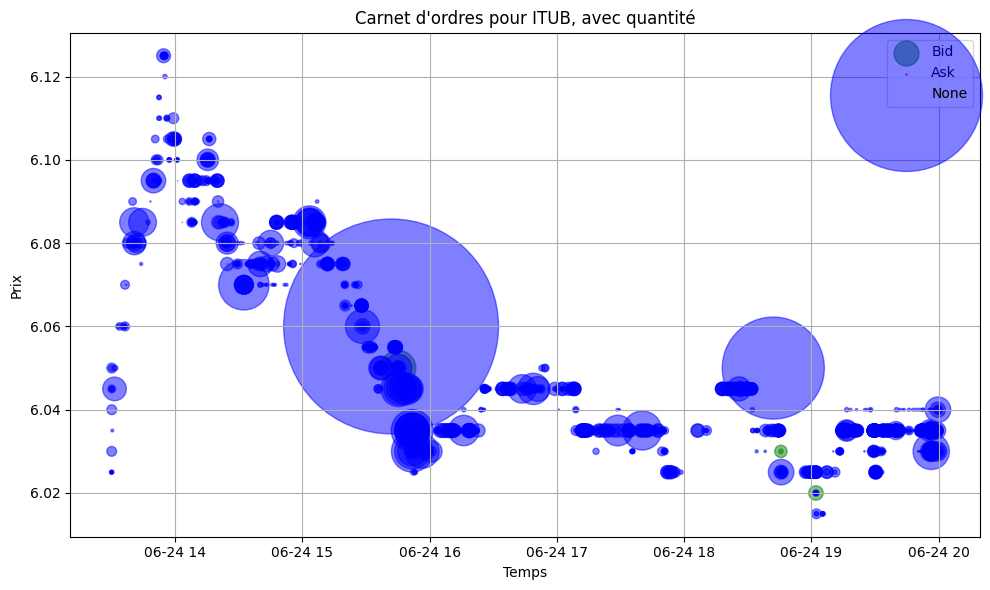

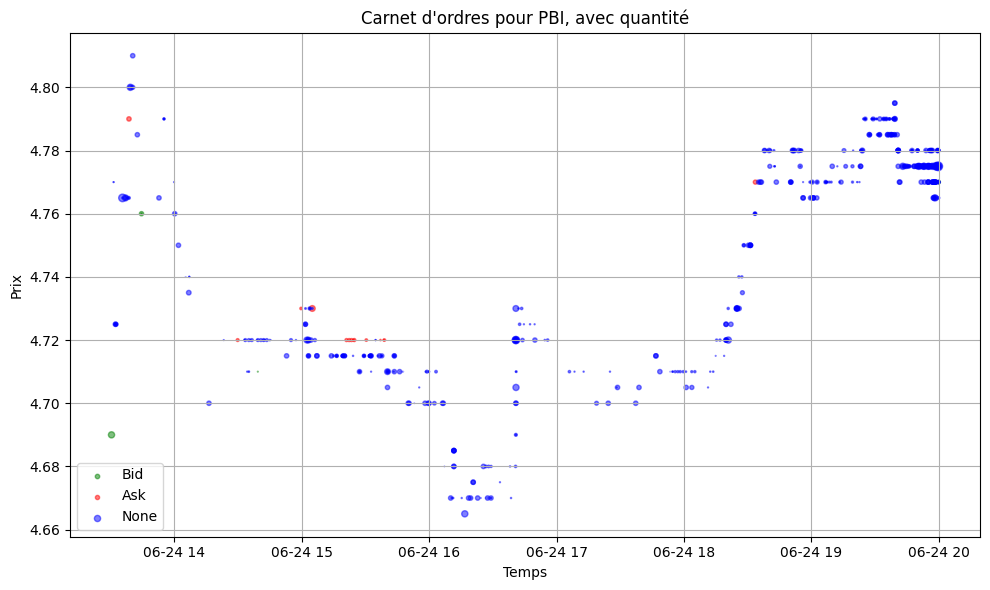

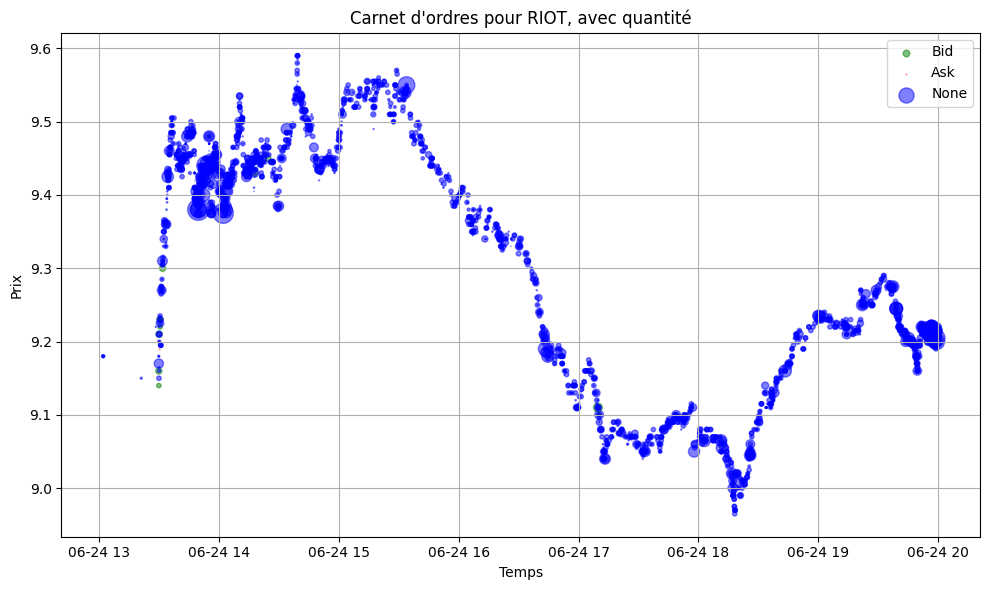

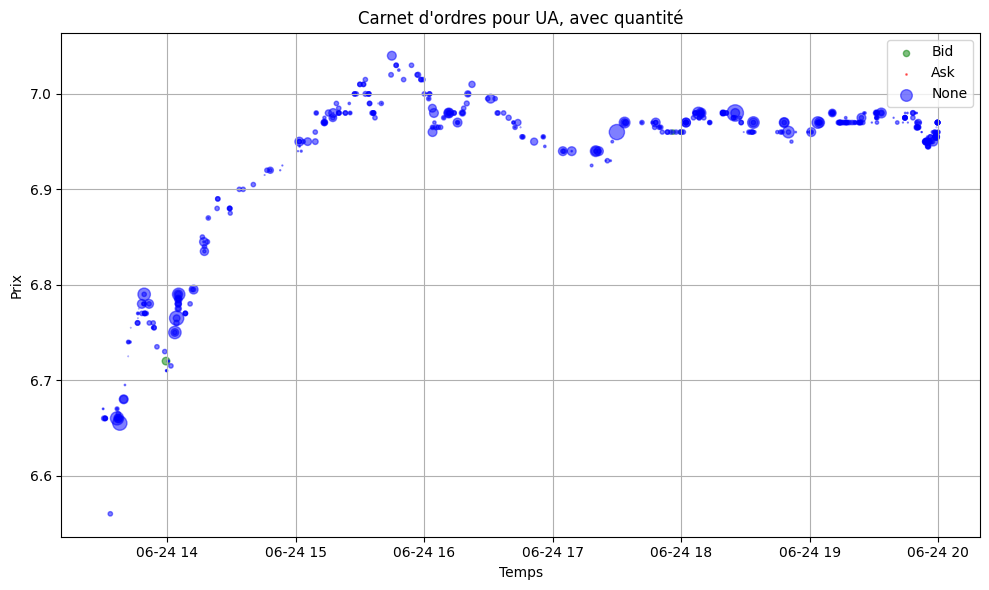

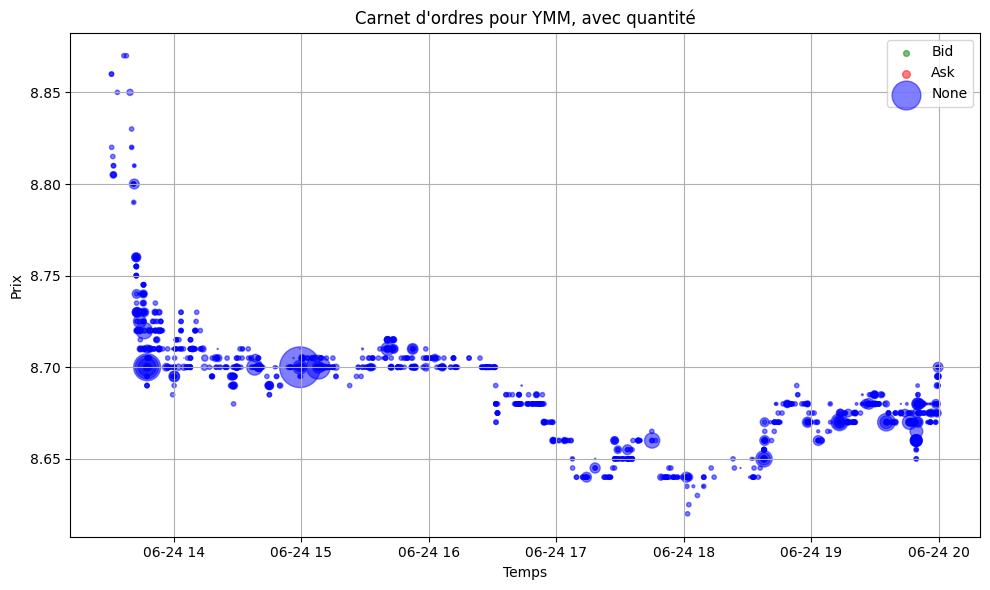

Bam ! Fichier décompressé dans : data/test
Pas de fichier DBN dans le dossier spécifique.


In [8]:

if __name__ == "__main__":
    main()
    
    # On applique le tout à test.zst
    specific_zst_path = "data/test.zst"
    specific_extract_path = specific_zst_path[:-4]  # On enlève l'extension .zst
    decompress_zst(specific_zst_path, specific_extract_path)
    
    # On charge les métadonnées et la symbologie spécifiques si elles existent
    specific_folder = os.path.dirname(specific_zst_path)
    specific_metadata = load_metadata(os.path.join(specific_folder, "metadata.json"))
    specific_symbology = load_symbology(os.path.join(specific_folder, "symbology.json"))
    
    # On cherche le fichier DBN spécifique
    specific_dbn_files = [f for f in os.listdir(specific_folder) if f.endswith('2.dbn')]
    if not specific_dbn_files:
        print("Pas de fichier DBN dans le dossier spécifique.")
    else:
        specific_dbn_file = os.path.join(specific_folder, specific_dbn_files[0])
        # On visualise le carnet d'ordres pour chaque symbole spécifique
        for symbol in specific_symbology['symbols']:
            visualize_orderbook(specific_dbn_file, symbol)


Temporal histogram

In [9]:
'''
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def visualize_orderbook_histogram(dbn_file, symbol, time_interval=60):
    """
    Visualise l'évolution du carnet d'ordres sous forme d'histogrammes en fonction du temps.
    
    :param dbn_file: Chemin vers le fichier DBN
    :param symbol: Symbole à visualiser
    :param time_interval: Intervalle de temps en secondes pour chaque histogramme
    """
    
    # Initialisation des structures de données
    bid_prices = defaultdict(list)
    bid_quantities = defaultdict(list)
    ask_prices = defaultdict(list)
    ask_quantities = defaultdict(list)
    
    # Lecture du fichier DBN
    with open(dbn_file, 'rb') as f:
        while True:
            message = read_message(f)
            if not message:
                break
            
            if message['type'] == 'L2' and message['symbol'] == symbol:
                timestamp =a message['timestamp']
                time_bucket = timestamp // time_interval
                
                for bid in message['bids']:
                    bid_prices[time_bucket].append(bid['price'])
                    bid_quantities[time_bucket].append(bid['quantity'])
                
                for ask in message['asks']:
                    ask_prices[time_bucket].append(-ask['price'])  # Prix négatif pour les asks
                    ask_quantities[time_bucket].append(ask['quantity'])
    
    # Création des histogrammes
    for time_bucket in sorted(bid_prices.keys()):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
        
        # Histogramme des prix
        ax1.hist(bid_prices[time_bucket], bins=50, alpha=0.5, label='Bids')
        ax1.hist(ask_prices[time_bucket], bins=50, alpha=0.5, label='Asks')
        ax1.set_title(f'Distribution des prix à {time_bucket * time_interval} secondes')
        ax1.set_xlabel('Prix (négatif pour les asks)')
        ax1.set_ylabel('Fréquence')
        ax1.legend()
        
        # Histogramme des quantités
        ax2.hist(bid_quantities[time_bucket], bins=50, alpha=0.5, label='Bids')
        ax2.hist(ask_quantities[time_bucket], bins=50, alpha=0.5, label='Asks')
        ax2.set_title(f'Distribution des quantités à {time_bucket * time_interval} secondes')
        ax2.set_xlabel('Quantité')
        ax2.set_ylabel('Fréquence')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

visualize_orderbook_histogram('data/test.dbn', 'BTCUSD', time_interval=300)
'''

'\nimport matplotlib.pyplot as plt\nimport numpy as np\nfrom collections import defaultdict\n\ndef visualize_orderbook_histogram(dbn_file, symbol, time_interval=60):\n    """\n    Visualise l\'évolution du carnet d\'ordres sous forme d\'histogrammes en fonction du temps.\n    \n    :param dbn_file: Chemin vers le fichier DBN\n    :param symbol: Symbole à visualiser\n    :param time_interval: Intervalle de temps en secondes pour chaque histogramme\n    """\n    \n    # Initialisation des structures de données\n    bid_prices = defaultdict(list)\n    bid_quantities = defaultdict(list)\n    ask_prices = defaultdict(list)\n    ask_quantities = defaultdict(list)\n    \n    # Lecture du fichier DBN\n    with open(dbn_file, \'rb\') as f:\n        while True:\n            message = read_message(f)\n            if not message:\n                break\n            \n            if message[\'type\'] == \'L2\' and message[\'symbol\'] == symbol:\n                timestamp =a message[\'timestamp\']\n